## 基于卷积神经网络的表情识别

### 1. 数据集介绍
- Fer2013人脸表情数据集由35886张人脸表情图片组成，其中，测试图（Training）28708张，公共验证图（PublicTest）和私有验证图（PrivateTest）各3589张，每张图片是由大小固定为48×48的灰度图像组成，共有7种表情，分别对应于数字标签0-6，具体表情对应的标签和中英文如下：

  0 anger 生气； 1 disgust 厌恶； 2 fear 恐惧； 3 happy 开心； 4 sad 伤心；5 surprised 惊讶； 6 normal 中性。

![表情类别.png](表情类别.png)

### 2.加载数据集
+ 数据文件包括三个：训练集train.csv，测试集test.csv，验证集，val.csv
+ csv文件中特征和标签没有分开，且特征值（像素值）是用空格隔开的字符串，需要拆分

In [1]:
import torch
import os
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import seaborn as sns
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# 数据给的是csv文件,其中的表情数据并没有直接给图片，而是给了像素值，没关系，整理的时候顺便转换成图片就好
train_d = pd.read_csv("./data/train.csv")
val_d = pd.read_csv("./data/val.csv")
test_d = pd.read_csv("./data/test.csv")
print("The sample number of Train data: ", train_d.shape[0])
print("The sample number of Valid data: ", val_d.shape[0])
print("The sample number of Test data: ", test_d.shape[0])

The sample number of Train data:  28709
The sample number of Valid data:  3589
The sample number of Test data:  3589


In [4]:
# train_d.iloc[0, 1]

In [5]:
# 处理训练集数据
X_train, y_train = [], []
pixels = train_d['pixels']
emotions = train_d['emotion']
for label, pixel in zip(emotions, pixels):
    pixel = np.array(pixel.split(' '), dtype='float32')
    X_train.append(pixel)
    y_train.append(label)
X_train = np.array(X_train).reshape(-1, 48, 48, 1)
y_train = np.array(y_train)

In [6]:
# 处理验证集数据
X_val, y_val = [], []
pixels = val_d['pixels']
emotions = val_d['emotion']
for label, pixel in zip(emotions, pixels):
    pixel = np.array(pixel.split(' '), dtype='float32')
    X_val.append(pixel)
    y_val.append(label)
X_val = np.array(X_val).reshape(-1, 48, 48, 1)
y_val = np.array(y_val)

In [7]:
# 处理测试集数据
X_test, y_test = [], []
pixels = test_d['pixels']
emotions = test_d['emotion']
for label, pixel in zip(emotions, pixels):
    pixel = np.array(pixel.split(' '), dtype='float32')
    X_test.append(pixel)
    y_test.append(label)
X_test = np.array(X_test).reshape(-1, 48, 48, 1)
y_test = np.array(y_test)

In [8]:
X_train.shape

(28709, 48, 48, 1)

In [9]:
def Handler(data):
    # 处理集数据
    X, y = [], []
    pixels = data['pixels']
    emotions = data['emotion']
    for label, pixel in zip(emotions, pixels):
        pixel = np.array(pixel.split(' '), dtype='float32')
        X.append(pixel)
        y.append(label)
    X = np.array(X).reshape(-1, 1, 48, 48)
    y = np.array(y)
    
    return X, y

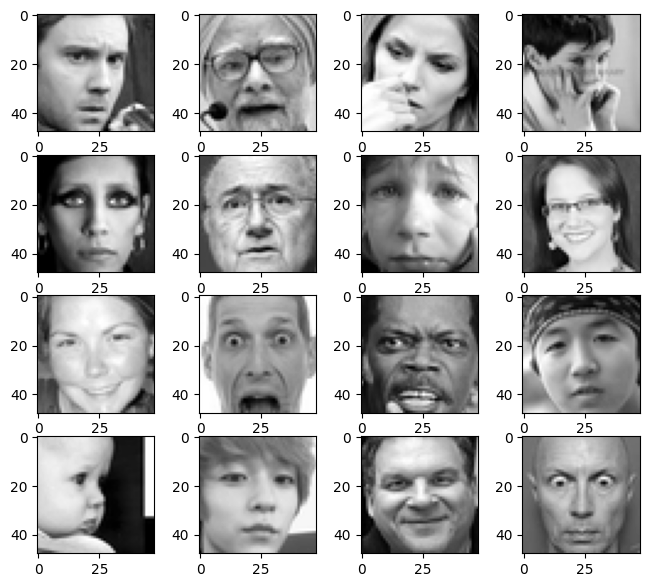

In [10]:
# 数据展示
fig = plt.figure(figsize=(8,7))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    plt.gray()
    ax.imshow(X_train[i])
plt.show()

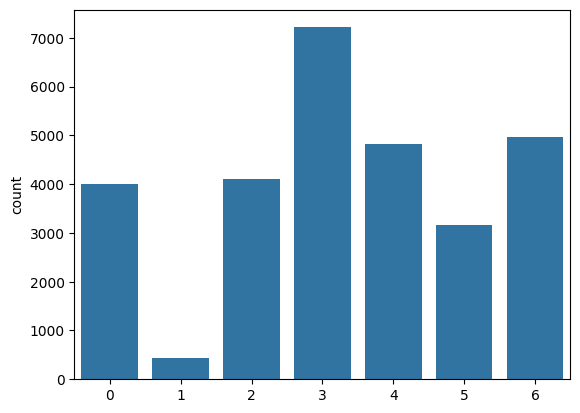

In [11]:
#各种表情种类的分布
sns.countplot(x=y_train)
plt.show()

### 3.构造自己的数据集

In [12]:
class FerDataset(Dataset):
    def __init__(self, path_dir, transform=None, target_transform=None):
        MyData = pd.read_csv(path_dir)
        X, y = Handler(MyData)
        self.img_labels = y
        self.img = X
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [13]:
# Data loader
batch_size = 200
train_dataset = FerDataset("./data/train.csv")
val_dataset = FerDataset("./data/val.csv")
test_dataset = FerDataset("./data/test.csv")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

### 3.搭建卷积神经网络

In [14]:
#超参数
num_epochs = 20
lr = 0.001

In [15]:
# class Reshape(nn.Module):
#     def __init__(self, *args):
#         super(Reshape, self).__init__()

#     def forward(self, x):
#         return x.view(x.shape[0],-1)

In [16]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=7):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(4608, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [17]:
len(train_loader)

144

In [27]:
# cnn = ConvNet.to(device)
cnn = ConvNet()
# print("training on", device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
# 初始化准确率记录列表
train_acc_history = []
val_acc_history = []

# Train the model
for epoch in range(num_epochs):
    train_loss = 0
    validation_loss = 0
    train_correct = 0
    val_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images
        labels = labels
        
        # Forward pass
        outputs = cnn(images)
        # print(outputs.shape)
        # print(labels.shape)
        # res = torch.tensor(outputs.max(dim=1).values, dtype=torch.float32)
        train_correct += (outputs.argmax(dim=1)==labels).sum()
        labels = labels.type(torch.LongTensor) 
        t1 = criterion(outputs, labels)
        train_loss += t1.item()
        
        # Backward and optimize
        optimizer.zero_grad()
        t1.backward()
        optimizer.step()

    #validate the model
    cnn.eval()
    for data,labels in val_loader:
        # data, labels = data.to(device), labels.to(device)
        val_outputs = cnn(data)
        labels = labels.type(torch.LongTensor)
        t2 = criterion(val_outputs, labels)
        validation_loss += t2.item()
        _, val_preds = torch.max(val_outputs,1)
        val_correct += torch.sum(val_preds == labels.data)

    train_loss = train_loss/len(train_dataset)
    train_acc = train_correct / len(train_dataset)
    validation_loss =  validation_loss / len(val_dataset)
    val_acc = val_correct.double() / len(val_dataset)
        
    print('Epoch [{}/{}], Train Accuracy: {:.4f}, Val Accuracy: {:.4f}'
           .format(epoch+1, num_epochs, train_acc, val_acc))
    # 将准确率添加到历史记录列表
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

Epoch [1/20], Train Accuracy: 0.3459, Val Accuracy: 0.4252
Epoch [2/20], Train Accuracy: 0.4407, Val Accuracy: 0.4475
Epoch [3/20], Train Accuracy: 0.4845, Val Accuracy: 0.4698
Epoch [4/20], Train Accuracy: 0.5130, Val Accuracy: 0.4912
Epoch [5/20], Train Accuracy: 0.5397, Val Accuracy: 0.5174
Epoch [6/20], Train Accuracy: 0.5630, Val Accuracy: 0.5110
Epoch [7/20], Train Accuracy: 0.5845, Val Accuracy: 0.5205
Epoch [8/20], Train Accuracy: 0.6014, Val Accuracy: 0.5104
Epoch [9/20], Train Accuracy: 0.6184, Val Accuracy: 0.5093
Epoch [10/20], Train Accuracy: 0.6358, Val Accuracy: 0.5074
Epoch [11/20], Train Accuracy: 0.6510, Val Accuracy: 0.5127
Epoch [12/20], Train Accuracy: 0.6692, Val Accuracy: 0.5194
Epoch [13/20], Train Accuracy: 0.6834, Val Accuracy: 0.4990
Epoch [14/20], Train Accuracy: 0.6965, Val Accuracy: 0.5032
Epoch [15/20], Train Accuracy: 0.7072, Val Accuracy: 0.5079
Epoch [16/20], Train Accuracy: 0.7180, Val Accuracy: 0.5163
Epoch [17/20], Train Accuracy: 0.7251, Val Accura

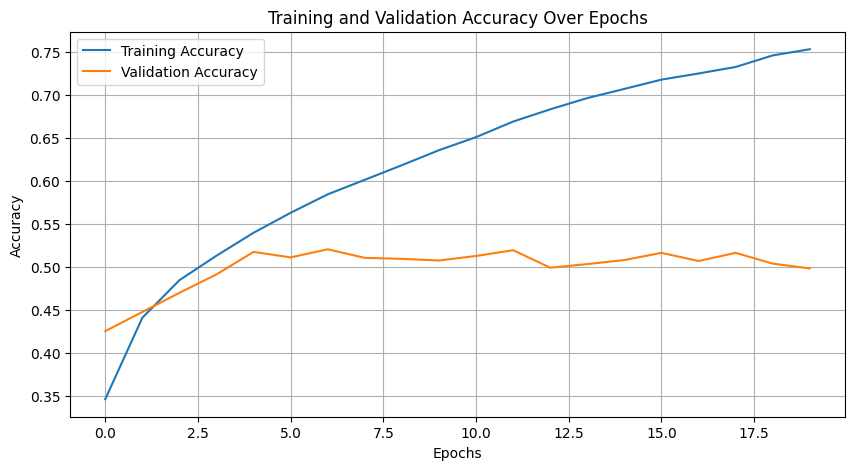

In [28]:
# 绘制训练和验证准确率曲线
plt.figure(figsize=(10,5))
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# 测试模型
cnn.eval()  # 确保模型处于评估模式
with torch.no_grad():  # 不计算梯度，节省内存
    test_loss = 0
    test_correct = 0
    for data, labels in test_loader:
        outputs = cnn(data)
        loss = criterion(outputs, labels.type(torch.LongTensor))
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
    test_loss /= len(test_dataset)
    test_acc = test_correct.double() / len(test_dataset)
    print(f'\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
# 保存模型
model_path = "./model.pth"
torch.save(cnn.state_dict(), model_path)
print(f"Model saved to {model_path}")
# 如果需要在之后加载模型，可以使用以下代码
# loaded_model = ConvNet()
# loaded_model.load_state_dict(torch.load(model_path))
# loaded_model.eval()


Test Loss: 0.0087, Test Accuracy: 0.4929
Model saved to ./model.pth
